In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random
import seaborn as sns
%matplotlib inline

In [2]:
eeg = pd.read_csv('EEG_merged.csv')
eeg.head()

,subject ID,Video ID,Attention,Meditation,Raw,Delta,Theta,Alpha 1,Alpha 2,Beta 1,Beta 2,Gamma1,Gamma2,predefined label,Self-defined label,age,ethnicity,gender
0,0,0,56,43,278,301963,90612,33735,23991,27946,45097,33228,8293,0,0,25,Han Chinese,M
1,0,0,40,35,-50,73787,28083,1439,2240,2746,3687,5293,2740,0,0,25,Han Chinese,M
2,0,0,47,48,101,758353,383745,201999,62107,36293,130536,57243,25354,0,0,25,Han Chinese,M
3,0,0,47,57,-5,2012240,129350,61236,17084,11488,62462,49960,33932,0,0,25,Han Chinese,M
4,0,0,44,53,-8,1005145,354328,37102,88881,45307,99603,44790,29749,0,0,25,Han Chinese,M


Put column names in consistent format:

In [3]:
renamed = []
# build new list of column names
for col in list(eeg.columns):
    newval = col.lower().replace(' ', '')
    renamed.append(newval)  

eeg.columns = renamed
eeg.head()


subjectid
0    1261
1    1301
2    1284
3    1314
4    1295
5    1262
7    1276
8    1282
9    1261
dtype: int64

In [6]:
# id columns:
idcols = ['subjectid', 'videoid']

# numeric columns:
numcols = ['attention', 'meditation', 'raw', 'delta', 'theta', 'alpha1', 
           'alpha2', 'beta1', 'beta2', 'gamma1', 'gamma2']

# categorical columns:
catcols = ['ethnicity', 'gender', 'age']
# target predictor columns:
targetcols = ['predefinedlabel', 'self-definedlabel']

# set dummies on categorical columns:
catdummies = pd.get_dummies(eeg[catcols])

# convert eeg data to standard spreadsheet format:
stddata = pd.concat([eeg[idcols], eeg[numcols], catdummies, eeg[targetcols]], axis = 1)

# save dataset:
stddata.to_csv('eeg_standardspreadsheet.csv', index=False)

## Look at distributions of numeric colums:

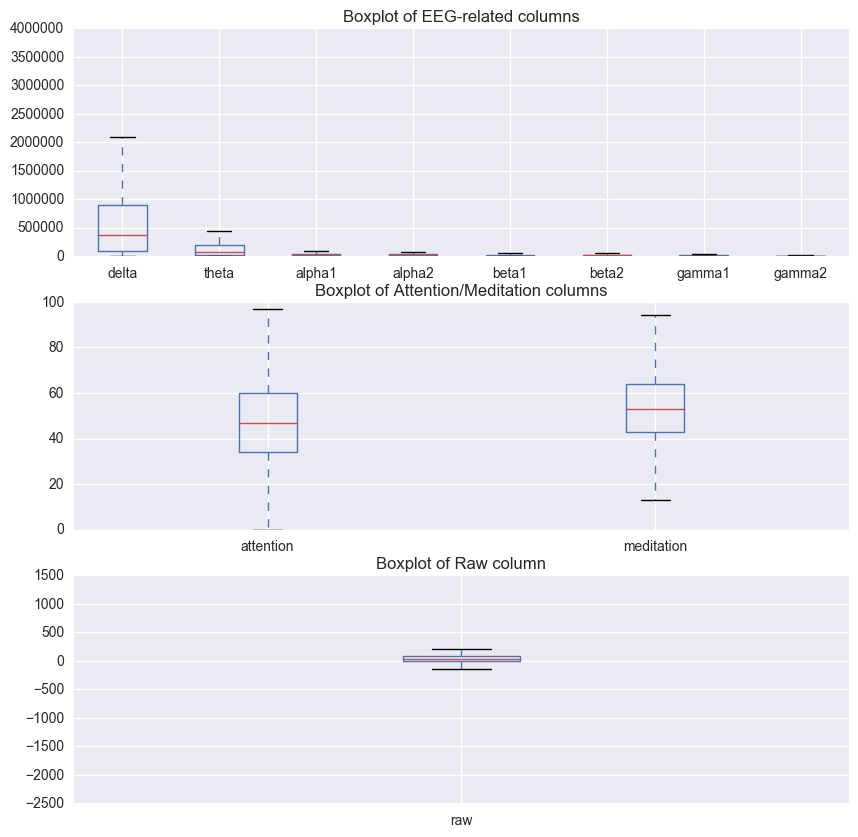

In [16]:
# all numeric columns other than attention, meditation, age:
eegcols = [col for col in numcols if col not in ['attention', 'meditation', 'raw']]
amcols = ['attention', 'meditation']
raw = ['raw']

fig = plt.figure(figsize = (10, 10))

plt.subplot(311)
stddata[eegcols].boxplot(return_type = 'axes')
plt.title('Boxplot of EEG-related columns')

plt.subplot(312)
stddata[amcols].boxplot(return_type = 'axes')
plt.title('Boxplot of Attention/Meditation columns')

plt.subplot(313)
stddata[raw].boxplot(return_type = 'axes')
plt.title('Boxplot of Raw column')

In [193]:
grp_labels = stddata[['subjectid', 'videoid', 'self-definedlabel']].groupby(['subjectid', 'videoid']).mean()

grp_age_eth_gen = stddata[['subjectid', 'videoid', 'age', 'ethnicity_Bengali', 'ethnicity_English', 
                        'ethnicity_Han Chinese', 'gender_F', 'gender_M']].groupby(['subjectid', 'videoid']).mean()


# for both raw values and log-normalized values:
# means
# medians
# max value
# min value
# range
# standard deviation
# skew

grpcols = idcols + numcols

mns = stddata[grpcols].groupby(['subjectid', 'videoid']).mean()
mns.rename(columns = lambda x: x + '_mean', inplace = True)

med = stddata[grpcols].groupby(['subjectid', 'videoid']).median()
med.rename(columns = lambda x: x + '_med', inplace = True)

mx  = stddata[grpcols].groupby(['subjectid', 'videoid']).max()
mx.rename(columns = lambda x: x + '_max', inplace = True)

mn  = stddata[grpcols].groupby(['subjectid', 'videoid']).min()
mn.rename(columns = lambda x: x + '_min', inplace = True)

rng = stddata[grpcols].groupby(['subjectid', 'videoid']).max() - stddata[grpcols].groupby(['subjectid', 'videoid']).min() 
rng.rename(columns = lambda x: x + '_range', inplace = True)

st_dev = stddata[grpcols].groupby(['subjectid', 'videoid']).std()
st_dev.rename(columns = lambda x: x + '_st_dev', inplace = True)

skw = stddata[grpcols].groupby(['subjectid', 'videoid']).skew()
skw.rename(columns = lambda x: x + '_skew', inplace = True)

features = pd.concat([mns, med, mx, mn, rng, st_dev, skw, grp_age_eth_gen], axis = 1)
features_cp = features

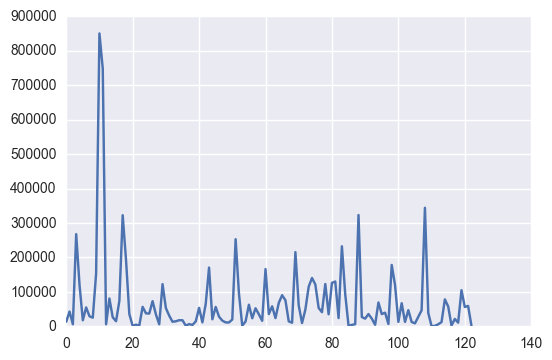

In [172]:
# Look at plots for individual subjectid - videoid combos
y = np.array(stddata.loc[(stddata['subjectid'] == 9) & (stddata['videoid'] == 5), 'alpha1'])
plt.plot(y)

In [147]:
from sklearn import tree, naive_bayes
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix, classification_report

In [252]:
cols = med.columns
X_features = features[cols].values
X_features_df = features[cols]
labels = grp_labels['self-definedlabel'] # make sure you extract the values this way, or you'll get errors

# build tree classifier:
treeclf = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split=10)
treeclf = treeclf.fit(X_features, grp_labels)

# naive bayes classifier:

In [255]:
#cv_scores = cross_validation.cross_val_score(treeclf, features, labels, cv = 10)

scores_vec = list(range(90))
preds_vec = list(range(90))

for i in range(90):
    cv_scores = cross_validation.cross_val_score(treeclf, X_features, labels, cv = 10)
    scores_vec[i] = cv_scores.mean()

cv_preds = cross_validation.cross_val_predict(treeclf, X_features, labels, cv = 10)
scores_vec = np.array(scores_vec)

Average Accuracy:
0.839111111111
Confusion Matrix:
[[40  4]
 [10 36]]
Classification Report:
             precision    recall  f1-score   support

          0       0.80      0.91      0.85        44
          1       0.90      0.78      0.84        46

avg / total       0.85      0.84      0.84        90



(array([  8.,   0.,  18.,   0.,  12.,  12.,   0.,  31.,   0.,   9.]),
 array([ 0.81555556,  0.81980556,  0.82405556,  0.82830556,  0.83255556,
         0.83680556,  0.84105556,  0.84530556,  0.84955556,  0.85380556,
         0.85805556]),
 <a list of 10 Patch objects>)

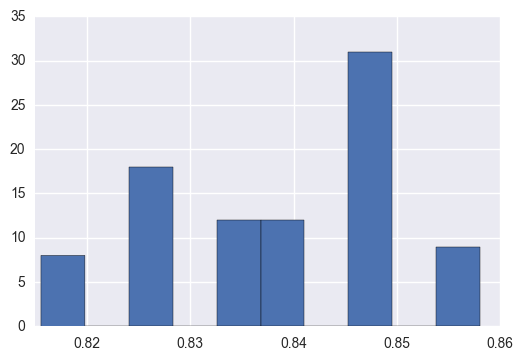

In [256]:
treecm = confusion_matrix(labels, cv_preds)
print('Average Accuracy:')
print(scores_vec.mean())
print('Confusion Matrix:')
print(treecm)
print('Classification Report:')
print(classification_report(labels, cv_preds))

plt.hist(np.array(scores_vec))

In [176]:
import pydotplus
from sklearn.externals.six import StringIO

In [257]:
dot_data = StringIO()
tree.export_graphviz(treeclf, out_file = dot_data, 
                     feature_names = X_features_df.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("treeclassifier.pdf")

True

0.51111111111111107

Definite problems with skew and different scales to the predictors.

## Transform Numeric columns to normalize & rescale:

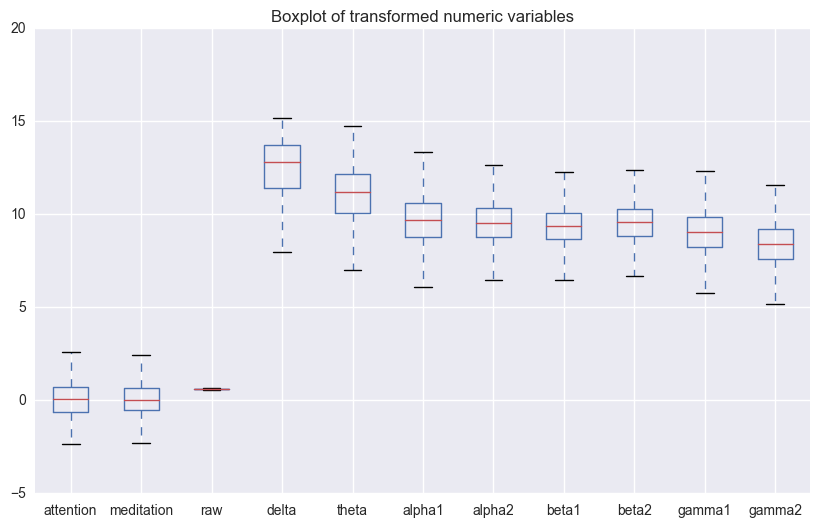

In [7]:
# log transform skewed columns:
eeg_logtransform = stddata[eegcols].apply(np.log, axis = 1)

# z scores for relatively normal columns:
attention_z = pd.DataFrame(stats.zscore(stddata[['attention']]))
meditation_z = pd.DataFrame(stats.zscore(stddata[['meditation']]))

att_med_zscores = pd.concat([attention_z, meditation_z], axis = 1)
att_med_zscores.columns = ['attention', 'meditation']

# min max transform for raw column:
raw_mm = (stddata[['raw']] - stddata[['raw']].min()) / (stddata[['raw']].max() - stddata[['raw']].min())

# concatenate transformed columns:
transformeddata = pd.concat([att_med_zscores, raw_mm, eeg_logtransform], axis = 1)

fig = plt.figure(figsize = (10, 6))
# display the results:
transformeddata.boxplot(return_type = 'axes')
plt.title('Boxplot of transformed numeric variables')

Still have some issues with the variables being on different scaless and with outliers.

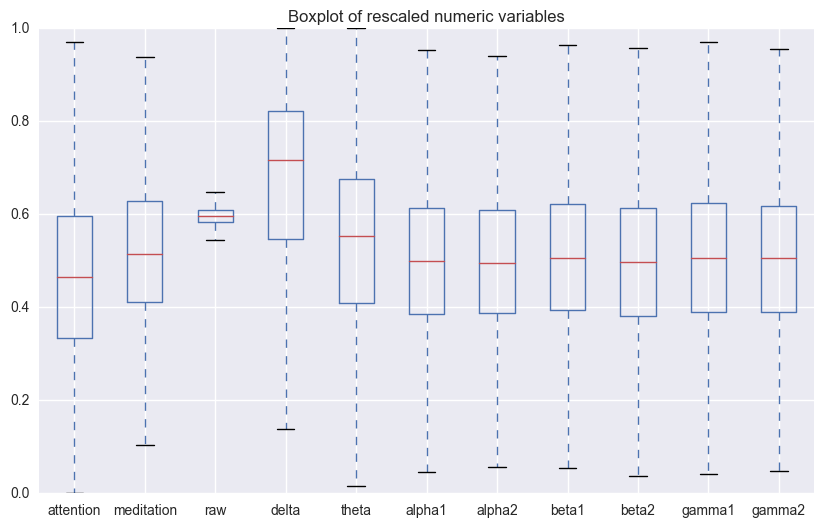

In [8]:
outlierrmcols = eegcols + amcols

# remove observations outside 3 standard deviations from the mean in the eeg columns:
for col in outlierrmcols:
    transformeddata = transformeddata[np.abs(transformeddata[col] - 
                                             transformeddata[col].mean()) <= (3.0 * transformeddata[col].std())]
# scale to a 0-1 interval:
for col in outlierrmcols:
    transformeddata[col] = (transformeddata[col] - transformeddata[col].min()) / \
    (transformeddata[col].max() - transformeddata[col].min())

# display results:  
fig = plt.figure(figsize = (10, 6))
transformeddata.boxplot(return_type = 'axes')
plt.title('Boxplot of rescaled numeric variables')

Now stratify the samples by subject ID after removing outliers

In [9]:
# remove records from the main dataset that contain outliers:
transformeddata_2 = stddata.ix[transformeddata.index.values, :]

# reset values in the 'transformeddata_2' set based on the transformed numerics:
transformeddata_2[transformeddata.columns] = transformeddata

# find the subjectid with the fewest number of observations to set sampling size:
counts = pd.DataFrame(transformeddata_2.groupby('subjectid').size().reset_index())
lowest = counts.loc[counts[0] == counts[0].min(), 'subjectid'].item()

# define list of subjects to sample (excluding lowest guy):
subs = list(transformeddata_2['subjectid'].unique())
subs.remove(lowest)

In [24]:
# initialize final dataframe with the data from the smallest guy:
finaldata = transformeddata_2.ix[transformeddata_2.subjectid == lowest, :].copy()
minrows = finaldata.shape[0]

np.random.seed(seed=1234)

# go through the rest of the subjects, sample, and concatenate with final dataframe:
for sub in subs:
    subset = transformeddata_2.ix[transformeddata_2.subjectid == sub, :]
    subsetidx = random.sample(list(subset.index.values), minrows)
    newdata = subset.ix[subsetidx, :]
    finaldata = pd.concat([finaldata, newdata], axis = 0)


finaldata.to_csv('EEG_norm_outliers_removed_strat.csv', index=False)

array(['subjectid', 'videoid', 'attention', 'meditation', 'raw', 'delta',
       'theta', 'alpha1', 'alpha2', 'beta1', 'beta2', 'gamma1', 'gamma2',
       'age', 'ethnicity_Bengali', 'ethnicity_English',
       'ethnicity_Han Chinese', 'gender_F', 'gender_M', 'predefinedlabel',
       'self-definedlabel'], dtype=object)

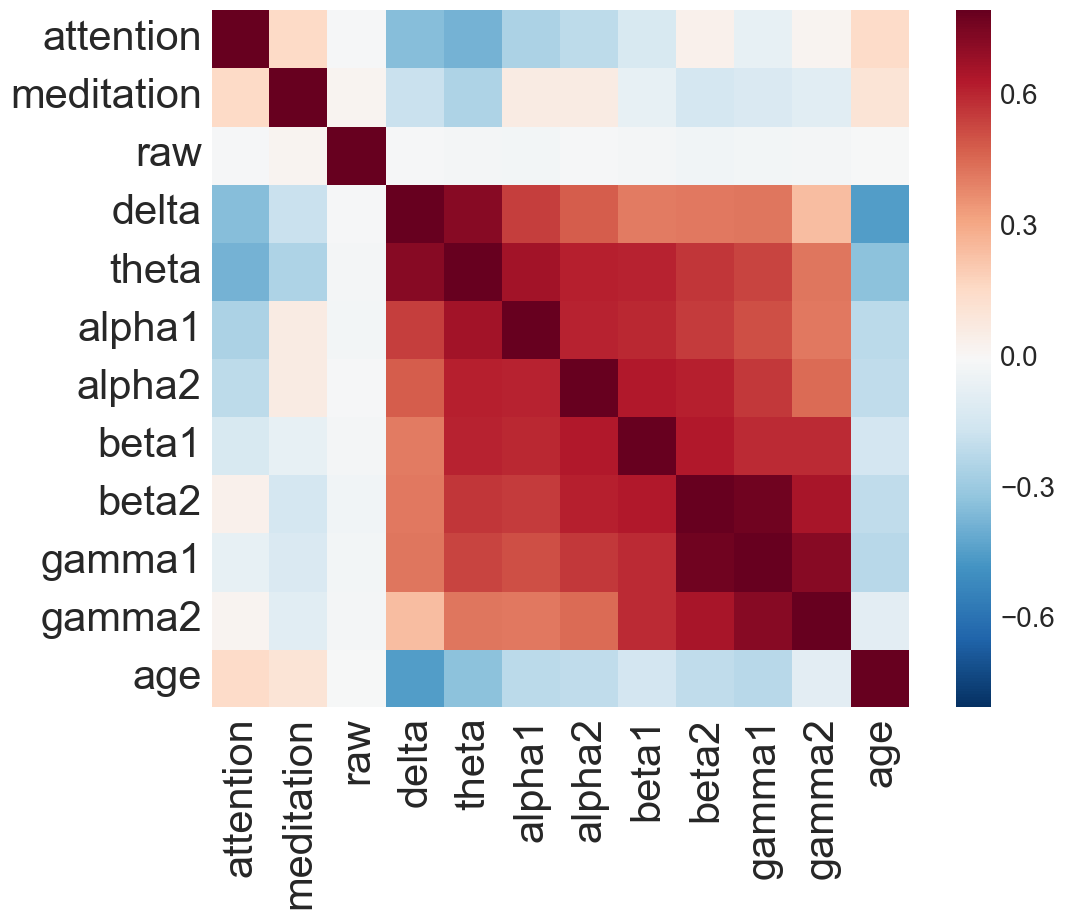

In [41]:
corrmat = finaldata[numcols].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn:
sns.set(font_scale=2)
sns.heatmap(corrmat, vmax=.8, square=True, label = 'large')

In [21]:
finaldata[numcols].corr()

,attention,meditation,raw,delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2,age
attention,1.000000,0.162218,-0.006534,-0.338434,-0.376462,-0.251079,-0.207212,-0.122430,0.040680,-0.062448,0.026073,0.153101
meditation,0.162218,1.000000,0.019043,-0.180107,-0.248418,0.065212,0.068662,-0.064234,-0.133583,-0.120730,-0.087769,0.108300
raw,-0.006534,0.019043,1.000000,-0.011602,-0.019705,-0.017908,-0.005914,-0.013741,-0.026230,-0.023229,-0.014957,-0.003598
delta,-0.338434,-0.180107,-0.011602,1.000000,0.728001,0.553020,0.480750,0.414304,0.418528,0.424705,0.248380,-0.443484
theta,-0.376462,-0.248418,-0.019705,0.728001,1.000000,0.672840,0.621160,0.615418,0.575150,0.546609,0.433881,-0.324243
alpha1,-0.251079,0.065212,-0.017908,0.553020,0.672840,1.000000,0.616153,0.601578,0.565270,0.520026,0.425739,-0.215739
alpha2,-0.207212,0.068662,-0.005914,0.480750,0.621160,0.616153,1.000000,0.636392,0.623398,0.562929,0.451809,-0.200325
beta1,-0.122430,-0.064234,-0.013741,0.414304,0.615418,0.601578,0.636392,1.000000,0.639619,0.598370,0.603695,-0.146368
beta2,0.040680,-0.133583,-0.026230,0.418528,0.575150,0.565270,0.623398,0.639619,1.000000,0.778067,0.665958,-0.205574
gamma1,-0.062448,-0.120730,-0.023229,0.424705,0.546609,0.520026,0.562929,0.598370,0.778067,1.000000,0.732107,-0.222453


### Pivot Tables for categorical variables

In [32]:
# recover Ethnicity value from booleans:
finaldata['gender'] = finaldata['gender_F'].apply(lambda x: 'F' if x == 1 else 'M')
finaldata.loc[finaldata['ethnicity_Bengali'] == 1, 'ethnicity'] = 'Bengali'
finaldata.loc[finaldata['ethnicity_English'] == 1, 'ethnicity'] = 'English'
finaldata.loc[finaldata['ethnicity_Han Chinese'] == 1, 'ethnicity'] = 'Han Chinese'


pd.crosstab(finaldata.ethnicity, finaldata.gender) / 1150

gender,F,M
ethnicity,,
Bengali,0.0,1.0
English,0.0,1.0
Han Chinese,2.0,5.0


Now make the final dataframe for analysis

## New section - group data at subjectid + videoid level before analysis:

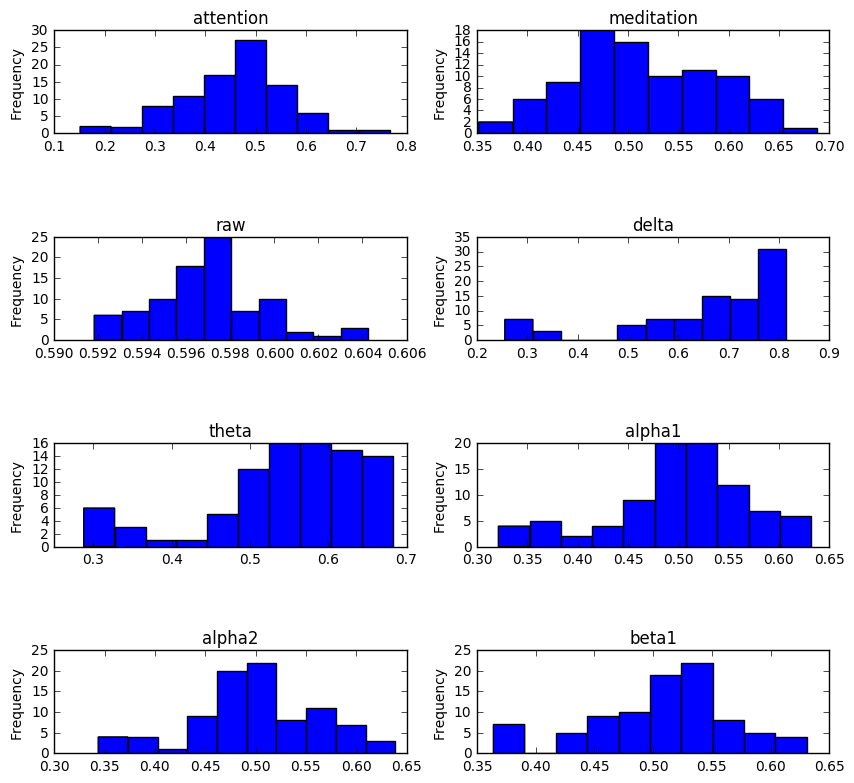

In [150]:
subvid = finaldata.groupby(['subjectid', 'videoid']).mean()

fig = plt.figure(figsize = (10, 20))
fig.subplots_adjust(hspace=1.0)

plt.subplot(821)
subvid['attention'].plot(kind = 'hist')
plt.title('attention')

plt.subplot(822)
subvid['meditation'].plot(kind = 'hist')
plt.title('meditation')

plt.subplot(823)
subvid['raw'].plot(kind = 'hist')
plt.title('raw')

plt.subplot(824)
subvid['delta'].plot(kind = 'hist')
plt.title('delta')

plt.subplot(825)
subvid['theta'].plot(kind = 'hist')
plt.title('theta')

plt.subplot(826)
subvid['alpha1'].plot(kind = 'hist')
plt.title('alpha1')

plt.subplot(827)
subvid['alpha2'].plot(kind = 'hist')
plt.title('alpha2')

plt.subplot(828)
subvid['beta1'].plot(kind = 'hist')
plt.title('beta1')


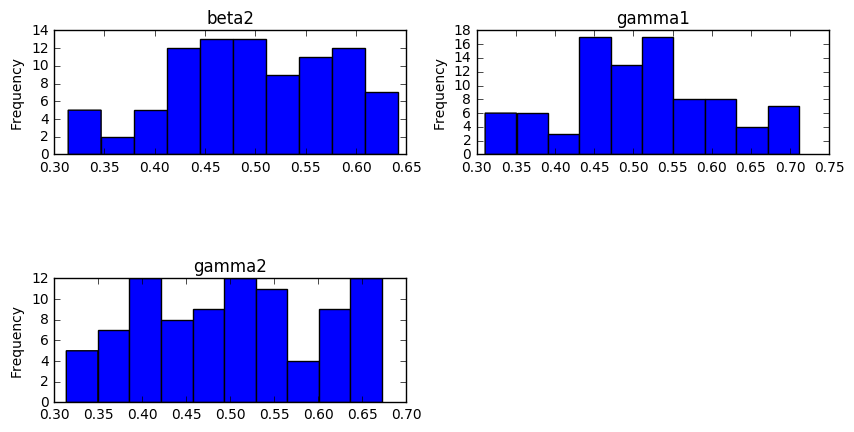

In [151]:
fig = plt.figure(figsize = (10, 8))
fig.subplots_adjust(hspace=1.0)

plt.subplot(321)
subvid['beta2'].plot(kind = 'hist')
plt.title('beta2')

plt.subplot(322)
subvid['gamma1'].plot(kind = 'hist')
plt.title('gamma1')

plt.subplot(323)
subvid['gamma2'].plot(kind = 'hist')
plt.title('gamma2')